In [1]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import script
import pandas as pd
import tqdm.notebook as tqdm
from multiprocessing import Pool
import seaborn as sns
import subprocess
import os
import pickle
import json 
plt.rcParams.update({'font.size': 15})

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
  
def save_runs(exp_root, exp_name, runs, args):
    git_hash = script.get_git_revision_hash()
    dirty = b'script.py' in subprocess.check_output(['git', 'diff', '--name-only'])
    exp_root = os.path.join(exp_root, f'{git_hash}-dirty' if dirty else f'{git_hash}')
    exp_dir = os.path.join(exp_root, exp_name)
    os.makedirs(exp_dir)
    with open(os.path.join(exp_dir, 'results'), 'wb') as f:
        pickle.dump(runs, f)
    with open(os.path.join(exp_dir, 'args' ), 'w') as f:
        json.dump(vars(args), f, indent=True, sort_keys=True, cls=NumpyEncoder)

def get_accepted_per_round(_runs, n_rounds):
  _list1 = []
  for _r in _runs:
    accepted_per_round = np.array(np.array_split(_r, n_rounds)).sum(axis=-1)
    rejected_per_round = 1 - accepted_per_round
    _list1.append(accepted_per_round)
  accepted_per_round = np.concatenate(_list1)
  return accepted_per_round

## harris et. al setup with selection

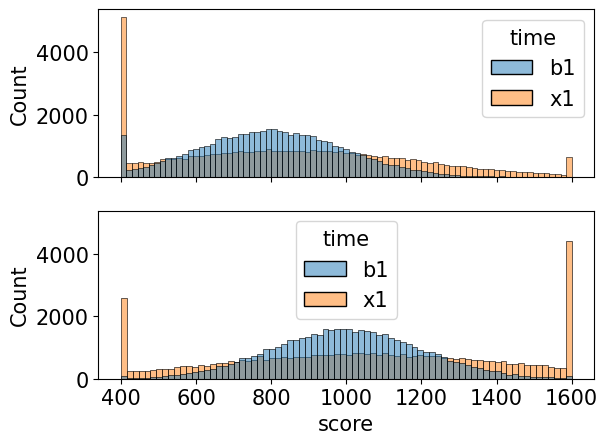

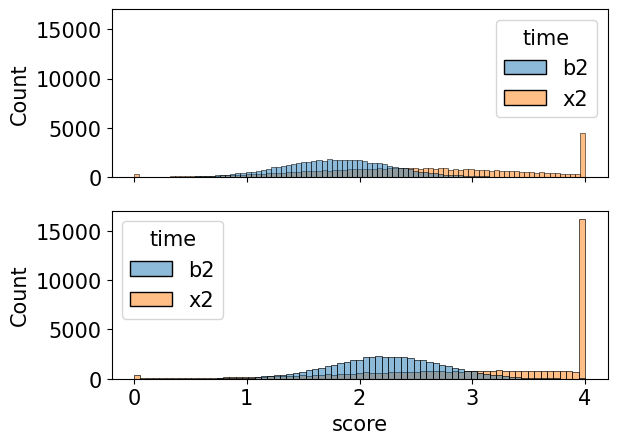

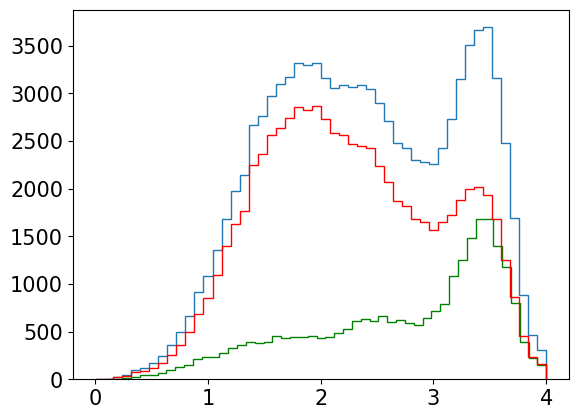

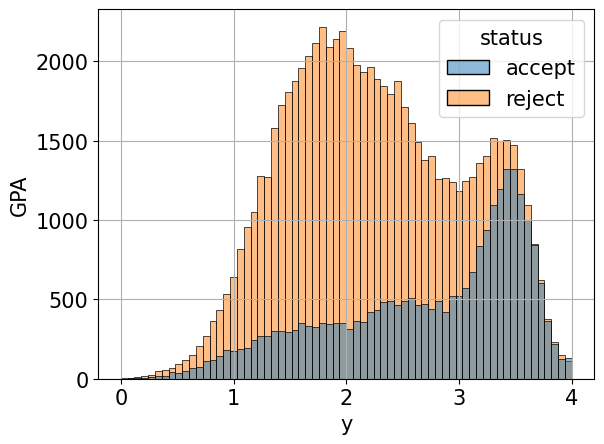

In [3]:
# plot data.
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --envs-accept-rates .25'
args = script.get_args(cmd)
np.random.seed(1)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = script.generate_data(
    args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args
    )

df0 = pd.DataFrame(
    {'b1': b[disadv_idx,0], 'b2': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     'x1': x[disadv_idx,0], 'x2': x[disadv_idx,1]},
)
df1 = pd.DataFrame(
    {'b1': b[adv_idx,0], 'b2': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx], 'x1': x[adv_idx, 0], 'x2': x[adv_idx, 1], 'y_hat': y_hat[0, disadv_idx]},
)
df0['class'] = 'disadv'
df1['class'] = 'adv'
df = pd.concat((df0, df1))
df
dflong = pd.melt(df, id_vars=('class'), value_vars=('b1', 'x1'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])

dflong = pd.melt(df, id_vars=('class'), value_vars=('b2', 'x2'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])
# fig,ax=plt.subplots()
# sns.histplot(df,x='y_hat',ax=ax)
# sns.histplot(df[df.status==1], x='y_hat', ax=ax)

fig,ax=plt.subplots()
plt.hist(y[0],  histtype='step', bins=50)
plt.hist(y[0][z==1],  histtype='step', color='g', bins=50)
plt.hist(y[0][z==0], histtype='step', color='r', bins=50)

dfa, dfr = pd.DataFrame({'y': y[0][z==1]}), pd.DataFrame({'y': y[0][z==0]})
dfa['status'] = 'accept'
dfr['status'] = 'reject'
df = pd.concat((dfa, dfr))
fig,ax=plt.subplots()
sns.histplot(df, x='y', hue='status', ax=ax)
ax.set_ylabel('GPA')
ax.grid()

# sns.histplot(df, x='y', ax=ax)

In [4]:
n_runs = 10
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --methods ols 2sls --envs-accept-rate .25'
args = script.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(script.run_multi_env, args_list )
runs = [r[0] for r in runs]

62it [00:00, 137.72it/s]
99it [00:00, 134.18it/s]
99it [00:00, 135.78it/s]
99it [00:00, 124.87it/s]
99it [00:00, 123.07it/s]
99it [00:00, 127.94it/s]
99it [00:00, 110.27it/s]
99it [00:00, 121.87it/s]
99it [00:00, 114.02it/s]
99it [00:01, 88.73it/s] 


In [8]:
# save_runs('experiments', 'harris-with-selection', runs, args)
#with open('/home/maadil/strategic-iv/experiments/38f2b2def647847bd85caa97013d0f522014871e/harris-with-selection/results', 'rb') as f:
    #runs = pickle.load(f)
# runs
# with open('/home/maadil/strategic-iv/experiments/f711f06/harris-with-selection/results', 'rb') as f:
    # runs = pickle.load(f)
# runs 

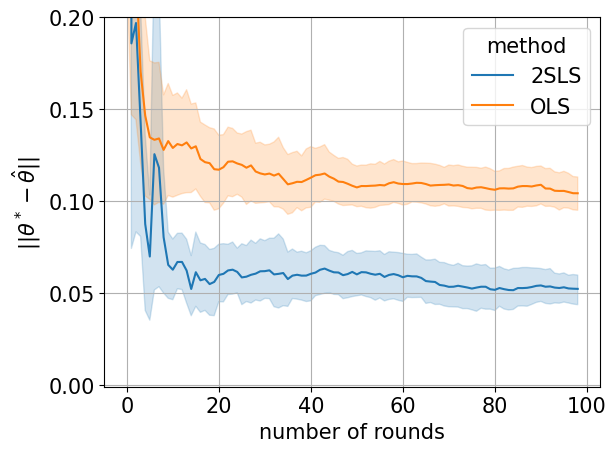

In [6]:
# converting to long format.
df = script.runs2df(runs)
dflong = pd.melt(df, id_vars='iterations', value_vars=('ols_env0', '2sls_env0'), var_name='method', value_name='error')
dflong['method'] = dflong['method'].astype('category')
dflong['method']= dflong['method'].cat.rename_categories({'ols_env0':'OLS', '2sls_env0': '2SLS'})

# plot
fig,ax=plt.subplots()
sns.lineplot(data=dflong, x='iterations', y='error', hue='method', ax=ax)
ax.set_ylim(bottom=-0.001, top=0.2)
ax.set_ylabel(r'$||\theta^* - \hat{\theta}|| $')
ax.set_xlabel('number of rounds')
ax.grid()

## our setup.

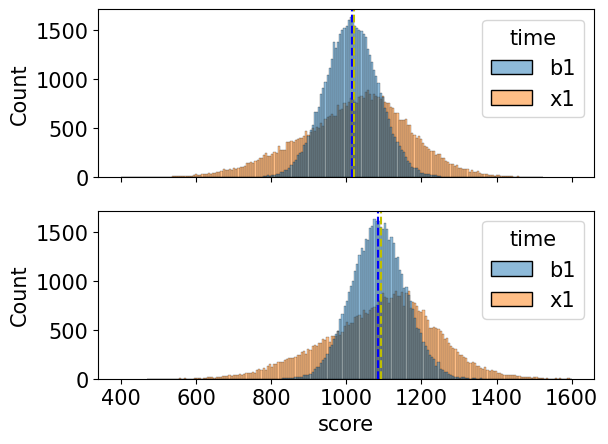

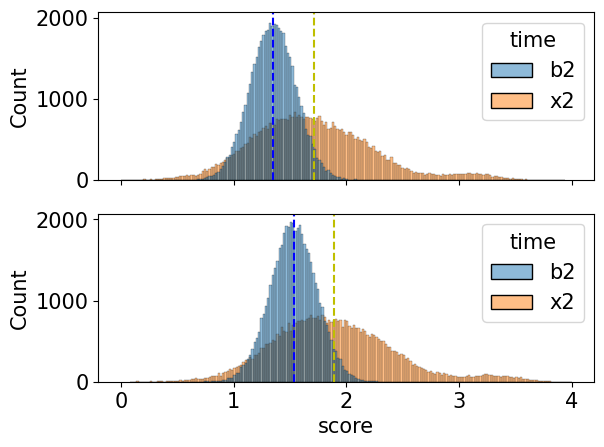

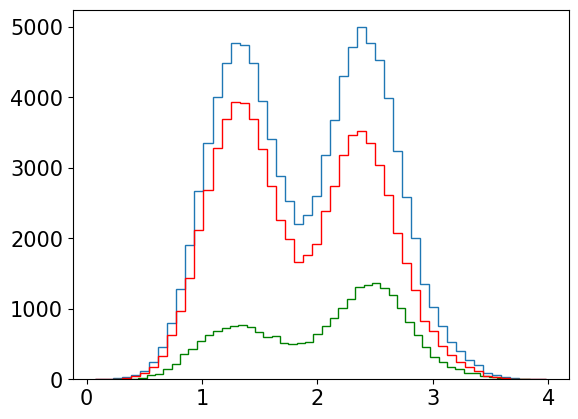

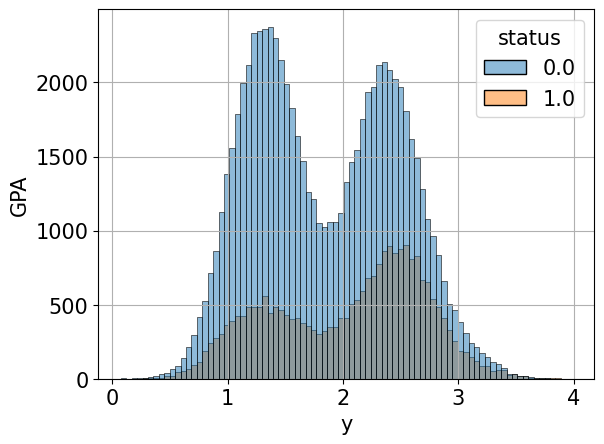

In [9]:
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours_vseq --envs-accept-rate .25'

args = script.get_args(cmd)
np.random.seed(1)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = script.generate_data(
    args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args
    )

df0 = pd.DataFrame(
    {'b1': b[disadv_idx,0], 'b2': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     'x1': x[disadv_idx,0], 'x2': x[disadv_idx,1]},
)
df1 = pd.DataFrame(
    {'b1': b[adv_idx,0], 'b2': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx], 'x1': x[adv_idx, 0], 'x2': x[adv_idx, 1], 'y_hat': y_hat[0, disadv_idx]},
)
df0['class'] = 'disadv'
df1['class'] = 'adv'
df = pd.concat((df0, df1))

# SAT score
dflong = pd.melt(df, id_vars=('class'), value_vars=('b1', 'x1'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])

# four mean lines
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time=='b1')].score.mean(), color='b', linestyle='--')
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time=='x1')].score.mean(), color='y', linestyle='--')

ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time=='b1')].score.mean(), color='b', linestyle='--')
ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time=='x1')].score.mean(), color='y', linestyle='--')

# GPA
dflong = pd.melt(df, id_vars=('class'), value_vars=('b2', 'x2'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])

# four mean lines
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time=='b2')].score.mean(), color='b', linestyle='--')
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time=='x2')].score.mean(), color='y', linestyle='--')

ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time=='b2')].score.mean(), color='b', linestyle='--')
ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time=='x2')].score.mean(), color='y', linestyle='--')

# College GPA (the target)
fig,ax=plt.subplots()
plt.hist(y[0],  histtype='step', bins=50)
plt.hist(y[0][z==1],  histtype='step', color='g', bins=50)
plt.hist(y[0][z==0], histtype='step', color='r', bins=50)

dfa, dfr = pd.DataFrame({'y': y[0][z==1]}), pd
fig,ax=plt.subplots()
sns.histplot(df, x='y', hue='status', ax=ax)
ax.set_ylabel('GPA')
ax.grid()

# sns.histplot(df, x='y', ax=ax)

In [10]:
n_runs = 10
args = script.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(script.run_multi_env, args_list )
    _runs = [r[2] for r in runs]
runs = [r[0] for r in runs]

95it [00:01, 57.23it/s]]
99it [00:01, 60.02it/s]]
99it [00:01, 68.01it/s]
99it [00:01, 69.94it/s]
91it [00:01, 40.80it/s] 
99it [00:01, 82.53it/s]
98it [00:01, 77.20it/s]
99it [00:01, 52.62it/s]

99it [00:01, 90.16it/s]


In [11]:
# save_runs('experiments', 'our-settings', runs, args)
# with open('experiments/f711f06/our-settings/results', 'rb') as f:
  # runs = pickle.load(f)
# runs

In [12]:
df = script.runs2df(runs)
# long format for plotting
value_vars = [f'{m}_env{e}' for m in args.methods for e in range(args.num_envs)]
dflong = pd.melt(df, id_vars='iterations', value_vars=value_vars, var_name='env', value_name='error')
dflong 
dflong['method'] = dflong.env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.env.apply(lambda x:x.split('_')[-1])
dflong['method'] = dflong['method'].astype('category')
dflong['method'] = dflong['method'].cat.rename_categories({'ours_vseq': 'Ours', 'ols': 'OLS', '2sls': '2SLS'})
dflong
dflong_stack = dflong # remember for later. 

In [13]:
## selection function variation. 
n_envs = 1
dfs = []
df_w = []
df_z = []
for env0_accept_rate in (.2, .4, .6, .8, 1.):
    # envs_accept_rates = np.linspace(env0_accept_rate, 1, num=n_envs)
    # envs_accept_rates = [str(x) for x in envs_accept_rates]
    # envs_accept_rates =' '.join(envs_accept_rates)
    
    cmd =f'--num-applicants 500000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours_vseq --offline-eval --envs-accept-rates {env0_accept_rate}'
    args = script.get_args(cmd)

    n_runs = 10
    args_list = [(s, args) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs_data = p.starmap(script.run_multi_env, args_list )
    
    # recording errors
    runs = [r[0] for r in runs_data]
    df = script.runs2df(runs)
    df['env0_accept_rate'] = env0_accept_rate
    dfs.append(df)
    
    # # recording w
    # runs_w = [r[1] for r in runs_data]
    # df = pd.DataFrame(np.sum(np.stack(runs_w), axis=-1))
    # df['env_accept_rate'] = env0_accept_rate
    # df_w.append(df)

    # recording z
    runs_z = [r[2] for r in runs_data]
    accepted_per_round = get_accepted_per_round(runs_z, args.num_applicants / args.applicants_per_round)
    df = pd.DataFrame({'accepted_per_round': accepted_per_round, 'env0_accept_rate': env0_accept_rate})
    df['rejected_per_round'] = args.applicants_per_round - df['accepted_per_round']
    df_z.append(df)

df = pd.concat(dfs)
# df_w = pd.concat(df_w)
df_z = pd.concat(df_z)
value_vars = [f'{m}_env{ei}' for m in args.methods for ei in range(args.num_envs)]
value_vars
dflong = pd.melt(df, id_vars='env0_accept_rate', value_vars=value_vars, value_name='error', var_name='method_env')
dflong['method'] = dflong.method_env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.method_env.apply(lambda x:x.split('_')[-1])  


1it [00:00,  5.36it/s]
1it [00:00,  4.52it/s]
1it [00:00,  5.94it/s]
1it [00:00,  3.91it/s]
0it [00:00, ?it/s]t/s]
1it [00:00,  3.56it/s]
1it [00:00,  3.12it/s]
1it [00:00,  3.46it/s]
1it [00:00,  5.84it/s]
1it [00:00,  6.57it/s]
1it [00:00,  5.84it/s]
1it [00:00,  3.91it/s]
1it [00:00,  3.51it/s]
1it [00:00,  3.10it/s]
1it [00:00,  3.78it/s]
0it [00:00, ?it/s]t/s]
1it [00:00,  5.11it/s]
1it [00:00,  2.85it/s]
1it [00:00,  6.14it/s]
1it [00:00,  6.88it/s]
1it [00:00,  5.02it/s]
1it [00:00,  3.34it/s]

1it [00:00,  3.34it/s]
1it [00:00,  4.21it/s]
1it [00:00,  2.92it/s]
1it [00:00,  2.79it/s]
1it [00:00,  3.48it/s]
1it [00:00,  2.92it/s]
1it [00:00,  3.65it/s]
1it [00:00,  3.41it/s]
1it [00:00,  3.72it/s]
1it [00:00,  2.91it/s]
1it [00:00,  2.82it/s]
1it [00:00,  4.14it/s]
1it [00:00,  3.00it/s]
1it [00:00,  3.55it/s]
1it [00:00,  2.63it/s]
0it [00:00, ?it/s]t/s]
1it [00:00,  4.03it/s]
0it [00:00, ?it/s]t/s]
1it [00:00,  2.68it/s]
1it [00:00,  2.56it/s]
1it [00:00,  2.32it/s]
1it [00:00

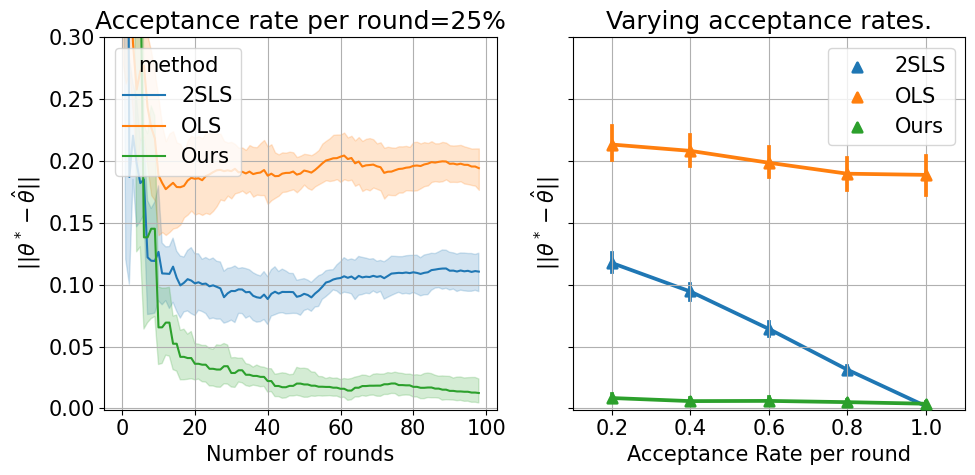

In [14]:
dflong
fig,ax=plt.subplots(ncols=2, figsize=(10, 5 ), sharey=True)

dflong['method'] = dflong['method'].astype('category')
dflong['method'] = dflong['method'].cat.rename_categories({'2sls': '2SLS', 'ols': 'OLS', 'ours_vseq': 'Ours'})
sns.pointplot(data=dflong[dflong.env=='env0'], x='env0_accept_rate', y='error', hue='method', markers='^')
ax[1].grid() 

sns.lineplot(dflong_stack, x='iterations', y='error', errorbar=('ci', 95), ax=ax[0], hue='method')
ax[0].grid()
ax[0].set_ylim(bottom=-0.001, top=.3)
ax[0].set_ylabel(r'$|| \theta^* - \hat{\theta}|| $')
ax[0].set_xlabel('Number of rounds')
ax[0].set_title('Acceptance rate per round=25%')

ax[1].set_xlabel('Acceptance Rate per round')
ax[1].set_ylabel(r'$|| \theta^* - \hat{\theta}|| $')

ax[1].set_title('Varying acceptance rates.')
ax[1].legend(loc='upper right')
plt.tight_layout()
plt.savefig('figures/single-env.pdf')

In [15]:
# save_runs('experiments', 'our-settings-single-env', (dflong_stack, dflong), args)

## multiple envs clone.

In [16]:
# cmd= f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours_vseq --envs-accept-rate .25'
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours_vseq --num-envs 2 --envs-accept-rate .25 .25'
args = script.get_args(cmd)

In [21]:
n_runs = 50
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(script.run_multi_env, args_list )
runs = [r[0] for r in runs]

99it [00:01, 52.19it/s] 
99it [00:01, 49.50it/s]]
99it [00:01, 61.98it/s] 
0it [00:00, ?it/s]
24it [00:00, 239.92it/s]
99it [00:01, 62.80it/s]]
51it [00:00, 62.50it/s] 
35it [00:00, 56.09it/s]]
99it [00:01, 62.44it/s]]
71it [00:01, 34.55it/s]
75it [00:01, 33.37it/s] 
2it [00:00, 19.49it/s]]]
51it [00:00, 72.84it/s]
3it [00:00, 29.30it/s]]]
59it [00:01, 41.80it/s]

80it [00:01, 34.82it/s]]
65it [00:01, 44.26it/s]
99it [00:01, 53.77it/s]]
0it [00:00, ?it/s]t/s]]]
99it [00:01, 62.16it/s]]
78it [00:01, 41.47it/s]]
44it [00:00, 102.69it/s]
35it [00:00, 102.45it/s]
31it [00:00, 69.13it/s]
62it [00:01, 51.33it/s]
20it [00:00, 81.25it/s]]
76it [00:00, 75.07it/s]]
99it [00:02, 48.53it/s]]
64it [00:00, 69.07it/s]]
64it [00:01, 65.20it/s]
66it [00:01, 52.04it/s] 
65it [00:01, 58.20it/s]]
99it [00:02, 49.22it/s]]
72it [00:01, 50.53it/s]]

0it [00:00, ?it/s]it/s]
91it [00:01, 41.59it/s]]
0it [00:00, ?it/s]it/s]
79it [00:01, 59.05it/s]
77it [00:00, 86.79it/s] 
94it [00:02, 40.22it/s]
99it [00:01, 77

In [22]:
# save_runs('experiments', 'multi-env-clone', runs, args)
# with open('experiments/f711f06/multi-env-clone/results', 'rb') as f:
  # runs = pickle.load(f)

In [23]:
df = script.runs2df(runs)
df
value_vars = [f'{m}_env{e}' for m in args.methods for e in range(args.num_envs)]
dflong = pd.melt(df, id_vars='iterations', value_vars=value_vars, var_name='env', value_name='error')
dflong['method'] = dflong.env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.env.apply(lambda x:x.split('_')[-1])
dflong

,iterations,env,error,method
0,0,env0,NaN,2sls
1,1,env0,0.744520,2sls
2,2,env0,0.037772,2sls
3,3,env0,0.039014,2sls
4,4,env0,0.022935,2sls
...,...,...,...,...
29695,94,env1,0.037037,ours_vseq
29696,95,env1,0.037037,ours_vseq
29697,96,env1,0.038445,ours_vseq
29698,97,env1,0.038445,ours_vseq


Text(0.5, 0, 'number of rounds')

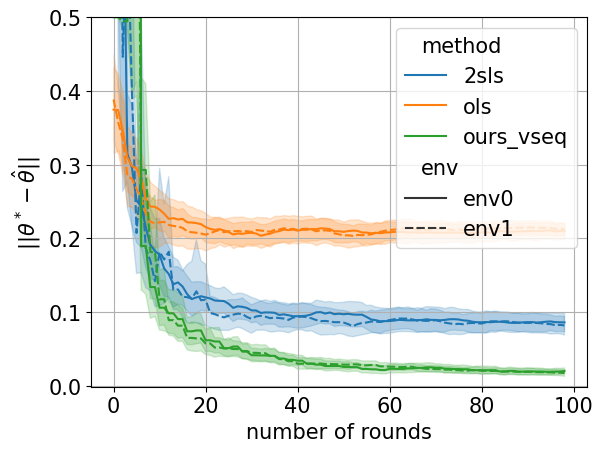

In [24]:
fig,ax=plt.subplots()
sns.lineplot(data=dflong, x='iterations', y='error', hue='method', style='env', errorbar=('ci', 95), ax=ax)
ax.grid()
ax.set_ylim(bottom=-.001, top=.5)
ax.set_ylabel(r'$ || \theta^* - \hat{\theta}|| $')
ax.set_xlabel('number of rounds')

## multi envs.

In [25]:
# acceptance rate experiments.
a1 = (.1, .25, .5, .75, .9)
a2 = (.1, .25, .5, .75, .9)
dfs = []
for _a1 in a1:
    for _a2 in a2:

        cmd =f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours_vseq --num-envs 2 --envs-accept-rate {_a1} {_a2} --theta-star-std 0.1 --offline-eval' # --envs-accept-rates .2 .6 1' # num accept rate 
        args = script.get_args(cmd)

        n_runs = 50  
        args_list = [(s, args) for s in np.arange(n_runs)]
        with Pool(n_runs) as p:
            runs = p.starmap(script.run_multi_env, args_list )
        runs = [r[0] for r in runs]

        df = script.runs2df(runs)
        df['a1'], df['a2'] = _a1, _a2
     
        dfs.append(df)

1it [00:00, 11.59it/s]
1it [00:00, 38.25it/s]
1it [00:00,  5.87it/s]
1it [00:00,  5.68it/s]
1it [00:00, 44.97it/s]
1it [00:00, 63.79it/s]
1it [00:00,  6.22it/s]
1it [00:00, 57.54it/s]
1it [00:00,  5.20it/s]
1it [00:00, 11.07it/s]
0it [00:00, ?it/s]t/s]
1it [00:00,  5.09it/s]
1it [00:00,  4.31it/s]
1it [00:00, 29.04it/s]
1it [00:00,  6.03it/s]
1it [00:00, 46.07it/s]
1it [00:00,  4.29it/s]
1it [00:00, 38.04it/s]

1it [00:00, 23.75it/s]
0it [00:00, ?it/s]t/s]
1it [00:00,  6.39it/s]

1it [00:00,  4.47it/s]

1it [00:00, 51.41it/s]
1it [00:00,  7.39it/s]
1it [00:00, 33.38it/s]


1it [00:00, 57.25it/s]

0it [00:00, ?it/s]t/s]
1it [00:00, 59.70it/s]
1it [00:00,  5.74it/s]

1it [00:00,  5.38it/s]

0it [00:00, ?it/s]t/s]
1it [00:00, 64.46it/s]
1it [00:00, 54.14it/s]

1it [00:00,  4.54it/s]

1it [00:00,  5.74it/s]
1it [00:00, 76.01it/s]


0it [00:00, ?it/s]t/s]
1it [00:00, 32.84it/s]

0it [00:00, ?it/s]t/s]
1it [00:00,  7.49it/s]
1it [00:00,  7.34it/s]
1it [00:00,  7.99it/s]

0it [00:00, ?it/s]t/

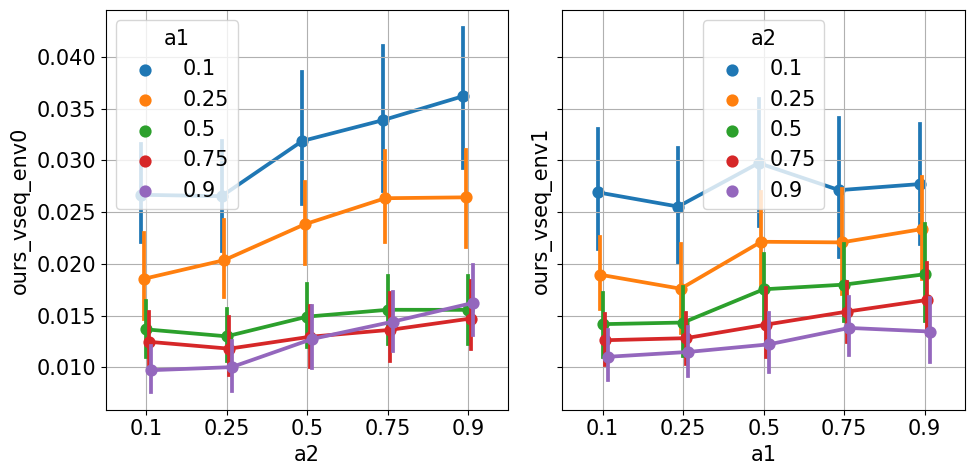

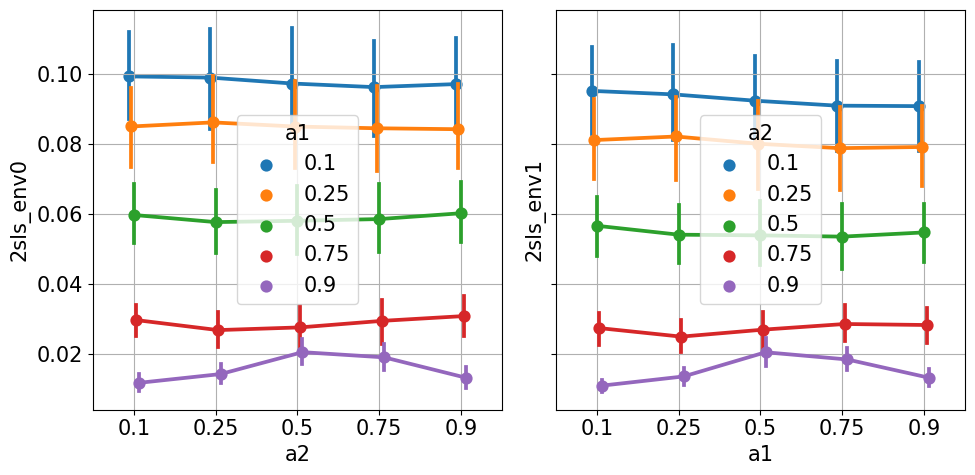

In [26]:
df = pd.concat(dfs)
fig, ax=plt.subplots(ncols=2, figsize=(10, 5), sharey=True)
sns.pointplot(df, x='a2', y='ours_vseq_env0', hue='a1', dodge=True, ax=ax[0])
sns.pointplot(df, x='a1', y='ours_vseq_env1', hue='a2', dodge=True, ax=ax[1])
ax[0].grid()
ax[1].grid()
plt.tight_layout() 

fig, ax=plt.subplots(ncols=2, sharey=True, figsize=(10, 5))
sns.pointplot(df, x='a2', y='2sls_env0', hue='a1', dodge=True, ax=ax[0])
sns.pointplot(df, x='a1', y='2sls_env1', hue='a2', dodge=True, ax=ax[1])
ax[0].grid()
ax[1].grid()
plt.tight_layout () 
# sns.pointplot(df, x='a2', y='ours_vseq_env0', hue='a2')

In [27]:
# save_runs('experiments', 'selection-acceptance-rates', runs, args)

## multiple environments (theta exp.)

In [35]:
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours_vseq --num-envs 3 --envs-accept-rate .25 .25 .25 --theta-star-std 0 --theta-per-env'
args = script.get_args(cmd)
np.random.seed(2)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = script.generate_data(
    args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args
    )

In [36]:
def add_envs(d, idx, var, prefix): 
    d.update({
        f'{prefix}_env{env_idx}': var[env_idx, idx] for env_idx in range(args.num_envs)
    })
    return d

# disadvantage class
df0 = {'b1': b[disadv_idx,0], 'b2': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     'x1': x[disadv_idx,0], 'x2': x[disadv_idx,1]}
df0 = add_envs(df0, disadv_idx, y, 'y')
df0 = add_envs(df0, disadv_idx, w, 'w')
df0.keys() 

df0 = pd.DataFrame(df0)
df0['class'] = 'disadv'

# advantaged class
df1 = {'b1': b[adv_idx,0], 'b2': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx],'y_hat': y_hat[0, adv_idx],
     'x1': x[adv_idx,0], 'x2': x[adv_idx,1]}
df1 = add_envs(df1, adv_idx, y, 'y')
df1 = add_envs(df1, adv_idx, w, 'w')
df1.keys() 

df1 = pd.DataFrame(df1)
df1['class'] = 'adv'
df = pd.concat((df0, df1))
df['status'] = df['status'].astype('category')
df


,b1,b2,status,y,y_hat,x1,x2,y_env0,y_env1,y_env2,w_env0,w_env1,w_env2,class
0,1067.769557,1.177815,2.0,1.332817,0.084388,1031.008372,1.872117,1.332817,1.268003,1.763233,0.0,1.0,0.0,disadv
1,928.647420,0.764346,0.0,1.856519,1.648174,1024.526863,2.486550,1.856519,1.776108,1.789633,0.0,0.0,0.0,disadv
2,921.635462,1.451358,2.0,1.445013,-0.460284,993.146325,2.117302,1.445013,1.780289,1.522159,0.0,1.0,0.0,disadv
3,963.364638,1.272386,0.0,1.083795,-0.109694,1006.745004,1.304372,1.083795,1.244792,1.361116,0.0,0.0,0.0,disadv
4,869.164072,1.528661,2.0,1.413531,-0.061723,885.634740,1.904152,1.413531,1.396740,1.207464,0.0,1.0,0.0,disadv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1079.794604,1.512832,3.0,1.996966,15.594219,1184.325455,1.313394,1.996966,2.096837,2.534689,1.0,0.0,1.0,adv
49996,835.139683,1.691467,3.0,2.958017,-1.590129,898.650810,2.459239,2.958017,2.520613,2.587422,0.0,0.0,1.0,adv
49997,1040.688768,0.820839,0.0,1.942712,-1.294456,965.288260,1.564756,1.942712,2.420574,2.103964,0.0,0.0,0.0,adv
49998,1002.011175,1.056677,0.0,2.505840,0.505847,1132.666932,1.889237,2.505840,2.436409,2.678954,0.0,0.0,0.0,adv


2.0151472641854418
2.1471302048320853
2.3043428981487004
2.3426852365321884


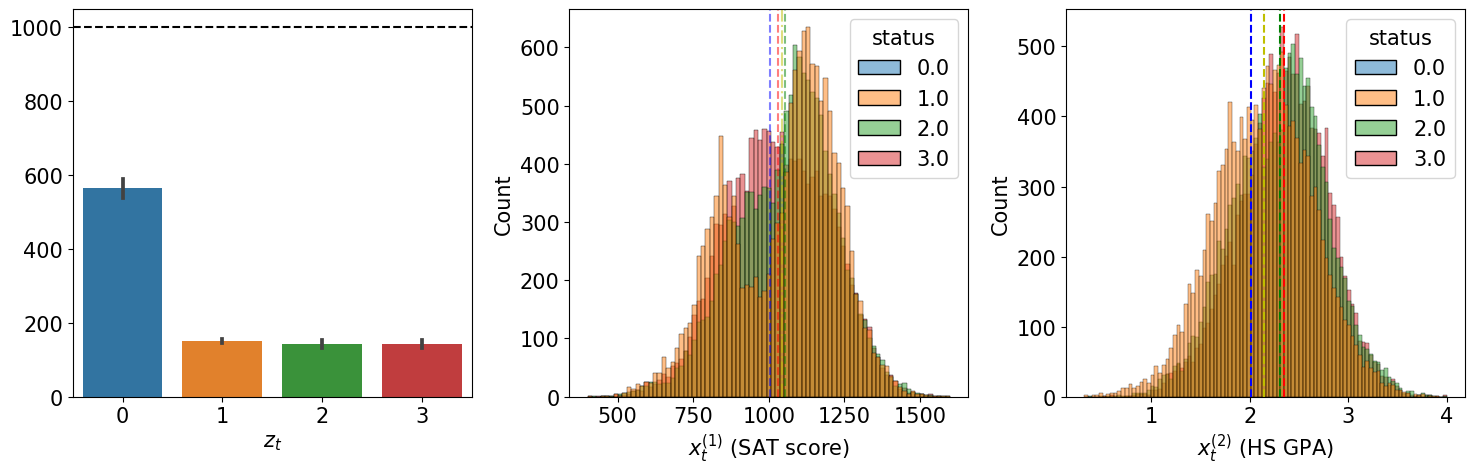

In [37]:

fig,ax=plt.subplots(ncols=3, figsize=(15, 5))

# first plot
df_z = pd.get_dummies(df['status'] ).to_numpy()
df_z = np.array(
  np.split(
    df_z, (args.num_applicants / args.applicants_per_round),  axis=0 
  )
)
ax[0].axhline(y=args.applicants_per_round, color='k', linestyle='--')

assert df_z.shape == ((args.num_applicants / args.applicants_per_round), args.applicants_per_round, args.num_envs+1), f"{df_z.shape}"
df_z = df_z.sum(axis=1) 
sns.barplot(pd.DataFrame(df_z), ax=ax[0])
ax[0].set_xlabel(r'$z_t$')

# second plot
sns.histplot(df[df.status!=0], x='x1', hue='status', ax=ax[1])
ax[1].axvline(x=df[df.status==0].x1.mean(), color='b', alpha=.5, linestyle='--')
ax[1].axvline(x=df[df.status==1].x1.mean(), color='y', alpha=.5, linestyle='-.')
ax[1].axvline(x=df[df.status==2].x1.mean(), color='g', alpha=.5, linestyle='--')
ax[1].axvline(x=df[df.status==3].x1.mean(), color='r', alpha=.5, linestyle='--')
ax[1].set_xlabel(r'$x_t^{(1)}$ (SAT score)')

# third plot
sns.histplot(df[df.status!=0], x='x2', hue='status', ax=ax[2])
for env_idx, c  in zip(range(args.num_envs+1), ('b', 'y', 'g', 'r')):
  print(df[df.status==env_idx].x2.mean())
  ax[2].axvline(x=df[df.status==env_idx].x2.mean(), c=c, linestyle='--')

# ax[2].axvline(x=df[df.status==3].x2.mean(), c='r', linestyle='-.', alpha=.5)
ax[2].set_xlabel(r'$x_t^{(2)}$ (HS GPA)')
plt.tight_layout() 

In [38]:
for env_idx in range(args.num_envs):
    print(df[df[f'w_env{env_idx}']==1][['x1']].mean()) 
for env_idx in range(args.num_envs):
    print(df[df[f'w_env{env_idx}']==1][['x2']].mean()) 
for env_idx in range(args.num_envs+1):
    print(df[df.status==env_idx][['x1']].mean()) 
for env_idx in range(args.num_envs+1):
    print(df[df.status==env_idx][['x2']].mean()) 

x1    1070.924744
dtype: float64
x1    1077.605124
dtype: float64
x1    1063.276566
dtype: float64
x2    2.234162
dtype: float64
x2    2.339637
dtype: float64
x2    2.371824
dtype: float64
x1    1004.666987
dtype: float64
x1    1044.763029
dtype: float64
x1    1054.939051
dtype: float64
x1    1030.305926
dtype: float64
x2    2.015147
dtype: float64
x2    2.14713
dtype: float64
x2    2.304343
dtype: float64
x2    2.342685
dtype: float64


In [39]:
n_runs = 50  
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(script.run_multi_env, args_list )
    
runs = [r[0] for r in runs]

99it [00:01, 67.04it/s]]
99it [00:01, 66.62it/s] 
75it [00:01, 64.77it/s]]
99it [00:01, 73.91it/s]]
99it [00:01, 72.07it/s]]
99it [00:00, 106.11it/s]
99it [00:01, 66.64it/s]
85it [00:00, 75.29it/s]]

99it [00:01, 82.81it/s] 
0it [00:00, ?it/s]4it/s]
99it [00:01, 97.56it/s] 
16it [00:00, 85.24it/s] 
99it [00:01, 88.08it/s]]
77it [00:01, 55.90it/s] 
0it [00:00, ?it/s]it/s]]
99it [00:01, 74.91it/s]
23it [00:00, 222.38it/s]
99it [00:01, 80.35it/s] 
56it [00:00, 54.16it/s]]
99it [00:01, 60.12it/s]]
57it [00:01, 43.78it/s] 
0it [00:00, ?it/s]it/s]]
39it [00:00, 50.81it/s] 
69it [00:01, 34.16it/s]]
4it [00:00, 36.59it/s]]]
69it [00:00, 59.72it/s]
0it [00:00, ?it/s]it/s] 
67it [00:00, 82.74it/s] 
12it [00:00, 59.00it/s]]
87it [00:01, 53.54it/s] 
77it [00:01, 54.30it/s]]
78it [00:01, 56.84it/s]]
9it [00:00, 81.17it/s]]
31it [00:00, 87.30it/s] 
99it [00:02, 43.70it/s]
99it [00:01, 65.30it/s]]
65it [00:01, 47.01it/s]]
90it [00:01, 38.11it/s]]
17it [00:00, 167.55it/s]
99it [00:02, 36.74it/s]]
57it

Text(0.5, 0, 'number of rounds')

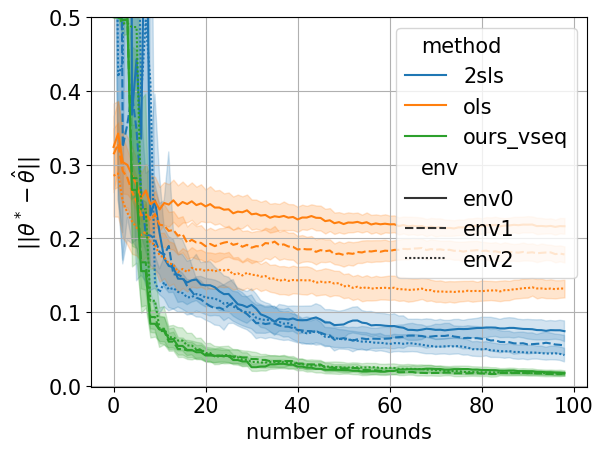

In [40]:
df = script.runs2df(runs)
df
value_vars = [f'{m}_env{e}' for m in args.methods for e in range(args.num_envs)]
dflong = pd.melt(df, id_vars='iterations', value_vars=value_vars, var_name='env', value_name='error')
dflong['method'] = dflong.env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.env.apply(lambda x:x.split('_')[-1])
dflong
fig,ax=plt.subplots()
sns.lineplot(data=dflong, x='iterations', y='error', hue='method', style='env', errorbar=('ci', 95), ax=ax)
ax.grid()
ax.set_ylim(bottom=-.001, top=.5)
ax.set_ylabel(r'$ || \theta^* - \hat{\theta}|| $')
ax.set_xlabel('number of rounds')

## preference vector.

In [52]:
def add_envs(d, idx, var, prefix): 
    d.update({
        f'{prefix}_env{env_idx}': var[env_idx, idx] for env_idx in range(args.num_envs)
    })
    return d
    
n_envs = 3
# pref_vects = [[1] * n_envs, [r+1 for r in range(n_envs)]]
# for i, p in enumerate(pref_vects): 
  # p = [_p / sum(p) for _p in p]
  # pref_vects[i] = p
# print(pref_vects)

pref_vects = [
   np.ones(shape=(n_envs,)), np.array([1, 2, 4]) 
]
dfs = []
for pref_convex_comb in (0, 1):
    p = (1-pref_convex_comb)* pref_vects[0] + (pref_convex_comb) * pref_vects[1]
    print(p )
    p_string = ' '.join([str(_p) for _p in p])
    cmd =f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours_vseq --num-envs {n_envs} --envs-accept-rate .25 .25 .25 --theta-star-std 0.1 --theta-per-env --pref-vect {p_string}'
    args = script.get_args(cmd)

    np.random.seed(1)
    b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = script.generate_data(
        args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args
        )
    df = {'x1': x[:,0], 'x2': x[:, 1], 'b1': b[:, 0], 'b2': b[:, 1], 'z': z}
    df = add_envs(df, np.arange(args.num_applicants), y, 'y')
    df = pd.DataFrame(df )
    df['pref_convex_comb'] = pref_convex_comb
    dfs.append(df )
df = pd.concat(dfs)

[1. 1. 1.]
[1. 2. 4.]


In [53]:
df.groupby('pref_convex_comb').mean()

,x1,x2,b1,b2,z,y_env0,y_env1,y_env2
pref_convex_comb,,,,,,,,
0,1021.496151,2.122639,961.013754,1.201364,0.86076,1.973195,2.049029,1.608274
1,1036.565911,2.156983,979.794369,1.097998,0.94944,1.988935,2.066007,1.618110


<AxesSubplot:xlabel='x2', ylabel='Count'>

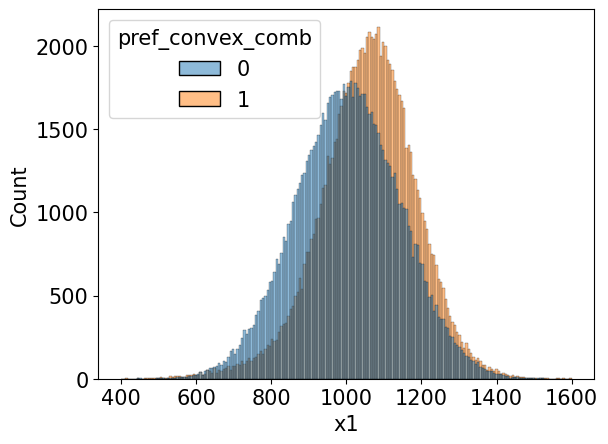

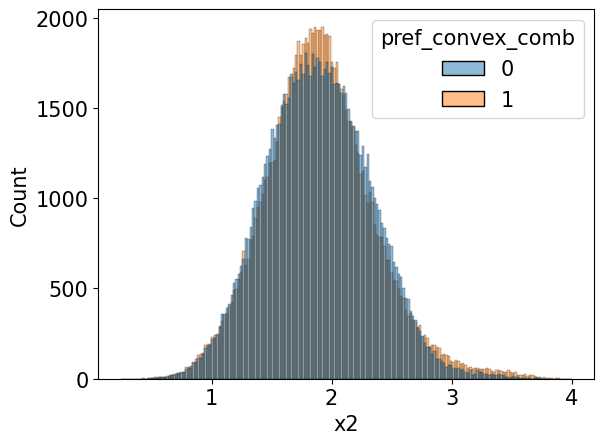

In [49]:
fig,ax=plt.subplots()
sns.histplot (data=df, x='x1', hue='pref_convex_comb')
fig,ax=plt.subplots()
sns.histplot (data=df, x='x2', hue='pref_convex_comb')

In [14]:


# disadvantage class
df0 = {'b1': b[disadv_idx,0], 'b2': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     'x1': x[disadv_idx,0], 'x2': x[disadv_idx,1]}
df0 = add_envs(df0, disadv_idx, y, 'y')
df0 = add_envs(df0, disadv_idx, w, 'w')
df0.keys() 

df0 = pd.DataFrame(df0)
df0['class'] = 'disadv'

# advantaged class
df1 = {'b1': b[adv_idx,0], 'b2': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx],'y_hat': y_hat[0, adv_idx],
     'x1': x[adv_idx,0], 'x2': x[adv_idx,1]}
df1 = add_envs(df1, adv_idx, y, 'y')
df1 = add_envs(df1, adv_idx, w, 'w')
df1.keys() 

df1 = pd.DataFrame(df1)
df1['class'] = 'adv'
df = pd.concat((df0, df1))
df['status'] = df['status'].astype('category')
df


,b1,b2,status,y,y_hat,x1,x2,y_env0,y_env1,y_env2,w_env0,w_env1,w_env2,class
0,980.579825,0.848634,0.0,1.470167,-0.622721,828.973019,2.299472,1.470167,1.607543,1.580299,0.0,0.0,0.0,disadv
1,972.662947,0.962004,0.0,1.168388,0.760684,1150.959353,1.401815,1.168388,1.334189,1.128068,0.0,0.0,0.0,disadv
2,1024.595249,0.836989,0.0,1.243416,-0.092549,1001.332335,1.181481,1.243416,0.958307,1.345111,0.0,0.0,0.0,disadv
3,816.869626,1.047356,1.0,0.896709,1.637917,943.440537,1.575386,0.896709,1.567097,1.222295,1.0,0.0,0.0,disadv
4,916.784811,0.626944,1.0,1.270146,3.823079,895.403517,1.133816,1.270146,1.424923,1.398406,1.0,0.0,0.0,disadv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1018.637872,0.923662,0.0,2.384785,0.849559,997.256578,1.430534,2.384785,2.028224,2.527716,0.0,0.0,0.0,adv
49996,1032.986796,1.086788,0.0,2.299692,-0.595503,994.462742,1.405004,2.299692,2.404645,2.308839,0.0,0.0,0.0,adv
49997,1063.822212,0.908028,1.0,2.371746,1.131287,1061.887211,1.926470,2.371746,2.622586,2.373585,1.0,0.0,0.0,adv
49998,1160.390414,1.118676,3.0,2.090304,-1.715982,1285.132745,1.353112,2.090304,2.475677,2.059821,0.0,1.0,1.0,adv


<AxesSubplot:xlabel='x1', ylabel='Count'>

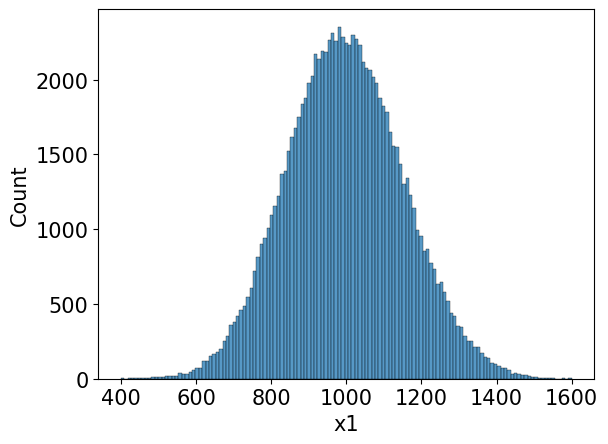

In [15]:
fig,ax=plt.subplots()
sns.histplot(data=df, x='x1')

In [ ]:

fig,ax=plt.subplots(ncols=3, figsize=(15, 5))

# first plot
df_z = pd.get_dummies(df['status'] ).to_numpy()
df_z = np.array(
  np.split(
    df_z, (args.num_applicants / args.applicants_per_round),  axis=0 
  )
)
ax[0].axhline(y=args.applicants_per_round, color='k', linestyle='--')

assert df_z.shape == ((args.num_applicants / args.applicants_per_round), args.applicants_per_round, args.num_envs+1), f"{df_z.shape}"
df_z = df_z.sum(axis=1) 
sns.barplot(pd.DataFrame(df_z), ax=ax[0])
ax[0].set_xlabel(r'$z_t$')

# second plot
sns.histplot(df[df.status!=0], x='x1', hue='status', ax=ax[1])
ax[1].axvline(x=df[df.status==0].x1.mean(), color='b', alpha=.5, linestyle='--')
ax[1].axvline(x=df[df.status==1].x1.mean(), color='y', alpha=.5, linestyle='-.')
ax[1].axvline(x=df[df.status==2].x1.mean(), color='g', alpha=.5, linestyle='--')
ax[1].axvline(x=df[df.status==3].x1.mean(), color='r', alpha=.5, linestyle='--')
ax[1].set_xlabel(r'$x_t^{(1)}$ (SAT score)')

# third plot
sns.histplot(df[df.status!=0], x='x2', hue='status', ax=ax[2])
for env_idx, c  in zip(range(args.num_envs+1), ('b', 'y', 'g', 'r')):
  print(df[df.status==env_idx].x2.mean())
  ax[2].axvline(x=df[df.status==env_idx].x2.mean(), c=c, linestyle='--')

# ax[2].axvline(x=df[df.status==3].x2.mean(), c='r', linestyle='-.', alpha=.5)
ax[2].set_xlabel(r'$x_t^{(2)}$ (HS GPA)')
plt.tight_layout() 

In [160]:
# # theta changing. 
# cmd =f'--num-applicants 300000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours_vseq --num-envs 3 --theta-star-std .1 --envs-accept-rates .2 .6 1'
# args = script.get_args(cmd)
# np.random.seed(1)
# b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = script.generate_data(
    # args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args
    # )

## protocol vs. no protocol

In [11]:
_runs = []
for protocol in (True, False):
    # cmd = f'--num-applicants 300000 --applicants-per-round 1000 --fixed-effort-conversion --scaled-duplicates sequence --b-bias 2 --num-envs 2 --pref uniform --methods ours'
    
    cmd = f'--num-applicants 500000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours_vseq --num-envs 2 --theta-star-std 1 --envs-accept-rates .25 --hs-gpa-std 5'
    if not protocol:
        cmd = f'{cmd} --no-protocol'
    print(cmd)
    
    args = script.get_args(cmd)
    n_runs = 50  
    args_list = [(s, args) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs = p.starmap(script.run_multi_env, args_list )
        _runs.append(runs)

--num-applicants 500000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours_vseq --num-envs 2 --theta-star-std 1 --envs-accept-rates .25 --hs-gpa-std 5


373it [00:12, 17.33it/s] 
431it [00:15, 15.99it/s]]
499it [00:16, 29.74it/s] 
468it [00:17, 15.95it/s]
474it [00:15, 14.40it/s]
404it [00:15, 15.20it/s]]
337it [00:10, 13.51it/s] 
467it [00:18, 13.45it/s]]
441it [00:19, 10.29it/s]
468it [00:18,  8.91it/s]]
462it [00:19, 12.17it/s]
479it [00:16, 15.58it/s]
102it [00:00, 91.09it/s] 
496it [00:17, 15.27it/s]]
426it [00:16, 12.88it/s] 
478it [00:16, 15.11it/s] 
480it [00:16, 15.11it/s] 
457it [00:18, 12.37it/s]]
180it [00:02, 52.40it/s]
169it [00:02, 39.66it/s] 
79it [00:00, 133.22it/s]
262it [00:05, 23.44it/s]]
483it [00:16, 14.95it/s]]
199it [00:02, 43.15it/s]]
475it [00:22, 13.10it/s]
390it [00:14, 15.09it/s]]
263it [00:04, 30.27it/s] 
169it [00:01, 58.31it/s]
400it [00:14, 14.13it/s] 
424it [00:19, 14.07it/s] 
460it [00:22, 13.07it/s]]
269it [00:06, 23.58it/s] 
499it [00:21, 23.49it/s]]
193it [00:02, 38.45it/s]]
416it [00:16, 14.28it/s]
307it [00:06, 24.07it/s] 
251it [00:04, 32.45it/s]
289it [00:05, 26.88it/s] 
349it [00:08, 21.35it/s

--num-applicants 500000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours_vseq --num-envs 2 --theta-star-std 1 --envs-accept-rates .25 --hs-gpa-std 5 --no-protocol


260it [00:05, 20.92it/s] 
325it [00:08, 17.93it/s]
282it [00:06, 20.72it/s]
432it [00:16,  9.63it/s] 
289it [00:06, 20.18it/s]
499it [00:20, 24.01it/s]
321it [00:08, 21.08it/s]
309it [00:07, 21.51it/s]]
402it [00:15, 15.65it/s] 
358it [00:10, 19.87it/s]
459it [00:19, 13.59it/s] 
499it [00:18, 26.95it/s] 
478it [00:20, 12.89it/s]
389it [00:11, 17.29it/s] 
215it [00:03, 35.78it/s]
342it [00:11, 13.73it/s]
427it [00:14,  9.34it/s]
389it [00:12, 15.94it/s]]
379it [00:14, 15.67it/s] 
446it [00:18, 12.84it/s]
389it [00:12, 16.93it/s]
157it [00:01, 48.06it/s]]
359it [00:09, 18.96it/s] 
464it [00:20, 10.61it/s]
230it [00:05, 21.07it/s]
93it [00:00, 157.27it/s]]
200it [00:04, 20.15it/s]]
297it [00:06, 19.10it/s] 
188it [00:03, 29.70it/s]]
234it [00:05, 25.99it/s] 
215it [00:04, 29.57it/s]]
326it [00:08, 19.94it/s]]
153it [00:01, 78.60it/s]
466it [00:17, 13.74it/s] 
488it [00:19, 11.13it/s]
192it [00:04, 10.50it/s]]
0it [00:00, ?it/s]2it/s]
162it [00:02, 47.05it/s]]
37it [00:00, 369.05it/s]
467i

In [12]:
runs0 = [r[0] for r in _runs[0]]
runs1 = [r[0] for r in _runs[1]]

In [13]:
df0 = script.runs2df(runs0)
df1 = script.runs2df(runs1)
df0['protocol'] = True
df1['protocol'] = False
df = pd.concat((df0, df1))
df

,iterations,ours_vseq_env0,ours_vseq_env1,protocol
0,0,2.264052,0.900157,True
1,1,2.264052,0.900157,True
2,2,2.263395,0.900081,True
3,3,2.263395,0.900081,True
4,4,0.054970,0.247823,True
...,...,...,...,...
24945,494,0.019071,0.239076,False
24946,495,0.019071,0.239076,False
24947,496,0.019059,0.239032,False
24948,497,0.019059,0.239032,False


In [14]:
dflong = pd.melt(df, id_vars=('iterations', 'protocol'), value_vars=('ours_vseq_env0', 'ours_vseq_env1'), var_name='env', value_name='error' )
dflong 

,iterations,protocol,env,error
0,0,True,ours_vseq_env0,2.264052
1,1,True,ours_vseq_env0,2.264052
2,2,True,ours_vseq_env0,2.263395
3,3,True,ours_vseq_env0,2.263395
4,4,True,ours_vseq_env0,0.054970
...,...,...,...,...
99795,494,False,ours_vseq_env1,0.239076
99796,495,False,ours_vseq_env1,0.239076
99797,496,False,ours_vseq_env1,0.239032
99798,497,False,ours_vseq_env1,0.239032


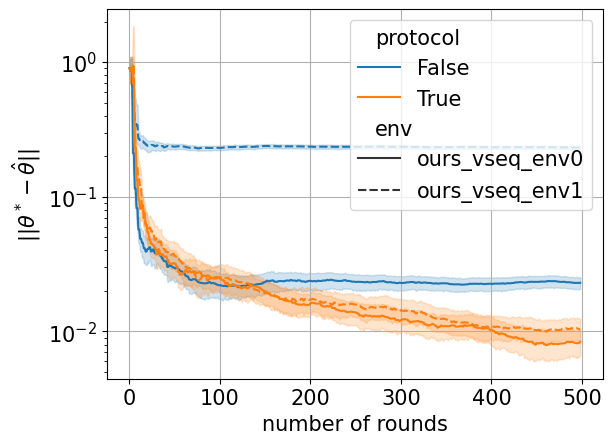

In [15]:
fig,ax=plt.subplots()
sns.lineplot(data=dflong, x='iterations', y='error', style='env',  hue='protocol')
ax.grid()
# ax.set_ylim(bottom=-.001, top=.5)
ax.set_xlabel('number of rounds')
ax.set_ylabel(r'$ || \theta^* - \hat{\theta}|| $')
# ax.set_ylim(top=.3)
ax.set_yscale('log')